In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.utils as vutils
import matplotlib.pyplot as plt

from discriminator import Discriminator
from generator import Generator

from torch.utils.data import DataLoader, Dataset


from utils import *
import torchvision
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:


def visualize(dataloader, netG, netD, criterion, epoch, fixed_noise, device):
    real_batch = next(iter(dataloader))
    y_labels = real_batch[1].to(device)
    real_batch = real_batch[0].to(device)
    
    batch_size = real_batch.size(0)
    label = torch.full((batch_size,), 1.0, device=device)
    output = netD(real_batch, y_labels).view(-1)
    errD_real = criterion(output, label)
    D_x = output.mean().item()

    fake = netG(fixed_noise, y_labels)
    label.fill_(0.0)
    output = netD(fake.detach(), y_labels).view(-1)
    errD_fake = criterion(output, label)
    D_G_z1 = output.mean().item()

    errD = errD_real + errD_fake

    label.fill_(1.0)
    output = netD(fake, y_labels).view(-1)
    errG = criterion(output, label)
    D_G_z2 = output.mean().item()

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
          % (epoch, 100, 0, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    

    fake = netG(fixed_noise, y_labels)
    

    # Plot the fake images from the last epoch
    plt.figure(figsize=(8,8))
    plt.title("Fake Images")
    for row in range(8):
        for col in range(8):
            plt.subplot(8, 8, row*8+col+1)
            plt.axis("off")
            # set subplot label to be the label of the image
            plt.title(y_labels[row*8+col].item())
            plt.imshow(fake[row*8+col].detach().cpu().squeeze(), cmap='gray')


    # Plot the real images from the last epoch
    plt.figure(figsize=(8,8))
    plt.title("Real Images")
    for row in range(8):
        for col in range(8):
            plt.subplot(8, 8, row*8+col+1)
            plt.axis("off")
            plt.imshow(real_batch[row*8+col].detach().cpu().squeeze(), cmap='gray')




In [6]:
modelG = Generator(32)
modelD = Discriminator()
IMG_SIZE = 32
checkpointG = torch.load('/ssd_scratch/cvit/anirudhkaushik/checkpoints/cganG_checkpoint_1_epoch.pt')
checkpointD = torch.load('/ssd_scratch/cvit/anirudhkaushik/checkpoints/cganD_checkpoint_1_epoch.pt')
modelG.load_state_dict(checkpointG['model'])
modelD.load_state_dict(checkpointD['model'])

modelG = modelG.to(device)
modelD = modelD.to(device)



data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])
train = torchvision.datasets.MNIST(root='/ssd_scratch/cvit/anirudhkaushik/datasets/', train=True, download=False, transform=data_transforms)
test = torchvision.datasets.MNIST(root='/ssd_scratch/cvit/anirudhkaushik/datasets/', train=False, download=False, transform=data_transforms)

data_loader = DataLoader(torch.utils.data.ConcatDataset([train, test]), batch_size=64, shuffle=True)


# visualize


[0/100][0/1094] Loss_D: 0.7948 Loss_G: 0.9646 D(x): 0.8318 D(G(z)): 0.4205 / 0.4205


/tmp/ipykernel_38700/4015830168.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 8, row*8+col+1)
/tmp/ipykernel_38700/4015830168.py:51: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 8, row*8+col+1)


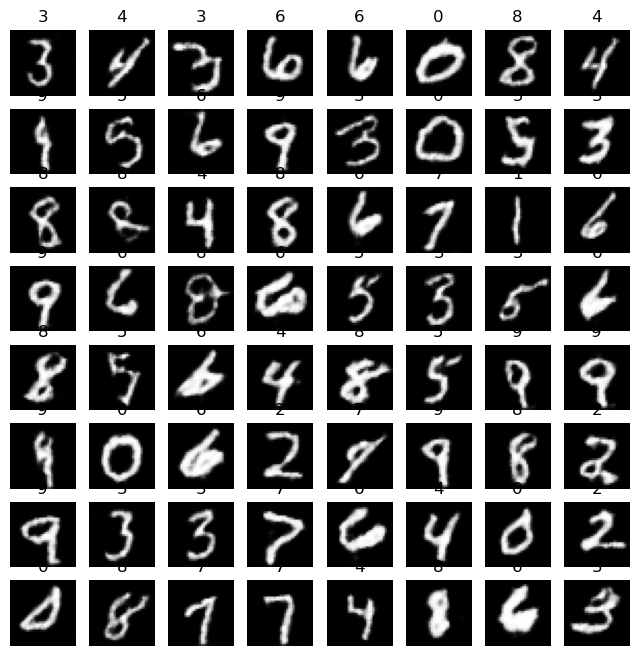

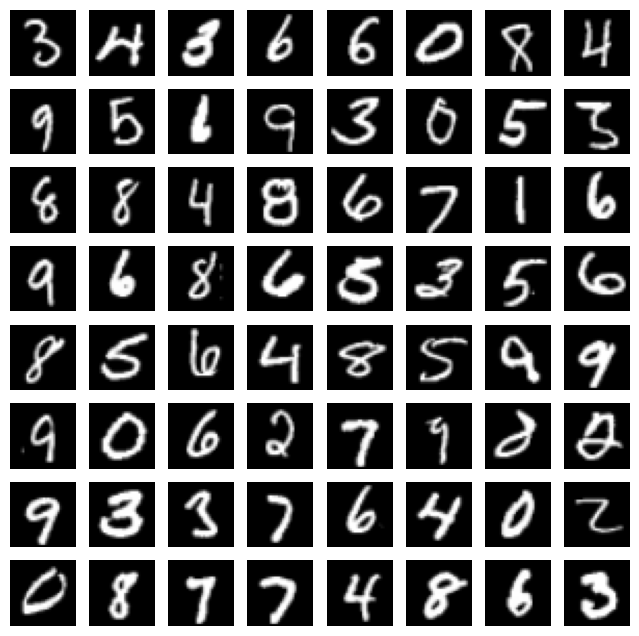

In [7]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

visualize(data_loader, modelG, modelD, criterion, 0, fixed_noise, device)